<a href="https://colab.research.google.com/github/Binkser/DSHSRP/blob/main/Research_Olympic_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

data = pd.read_csv('/content/athlete_events.csv')
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [ ]:
# Remove rows where no medal was awarded
medals = data.dropna(subset=['Medal'])

# Group by NOC (country code) and Year to get medal counts
medals_by_country_year = medals.groupby(['NOC', 'Year']).size().reset_index(name='Medal Count')

# Show first few rows
medals_by_country_year.head()


,NOC,Year,Medal Count
0,AFG,2008,1
1,AFG,2012,1
2,AHO,1988,1
3,ALG,1984,2
4,ALG,1992,2


In [ ]:
# Create a mapping from NOC to Team (country name)
noc_country_map = data[['NOC', 'Team']].drop_duplicates()

# Merge with your medals_by_country_year to add the country name
medals_with_country = medals_by_country_year.merge(noc_country_map, on='NOC', how='left')

medals_with_country = medals_with_country[['Team', 'NOC', 'Year', 'Medal Count']]

# Preview
medals_with_country.head()

,Team,NOC,Year,Medal Count
0,Afghanistan,AFG,2008,1
1,Afghanistan,AFG,2012,1
2,Netherlands Antilles,AHO,1988,1
3,Algeria,ALG,1984,2
4,Algeria,ALG,1992,2


In [ ]:
# Load GDP data (skip the top metadata rows)
gdp_raw = pd.read_csv('/content/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_38344.csv', skiprows=4)

# Melt to long format: one row per country-year
gdp_long = gdp_raw.melt(id_vars=['Country Name'], var_name='Year', value_name='GDP')

# Clean up year column
gdp_long['Year'] = pd.to_numeric(gdp_long['Year'], errors='coerce')

# Drop missing GDP or year values
gdp_cleaned = gdp_long.dropna(subset=['Year', 'GDP'])

gdp_cleaned.loc[:, 'GDP'] = gdp_cleaned['GDP'].round(0)

gdp_cleaned.head()

,Country Name,Year,GDP
799,Africa Eastern and Southern,1960.0,24209933140.9893
801,Africa Western and Central,1960.0,11905107707.334101
807,Argentina,1960.0,15865474315.4056
811,Australia,1960.0,18607682977.229301
812,Austria,1960.0,6624086313.14334


In [ ]:
# Merge GDP with medal data on country name and year
merged = medals_with_country.merge(
    gdp_cleaned,
    left_on=['Team', 'Year'],
    right_on=['Country Name', 'Year'],
    how='left'
)

# Drop the extra country name column
merged = merged.drop(columns=['Country Name'])

merged.head()


,Team,NOC,Year,Medal Count,GDP
0,Afghanistan,AFG,2008,1,10109297047.5432
1,Afghanistan,AFG,2012,1,19907329777.5872
2,Netherlands Antilles,AHO,1988,1,NaN
3,Algeria,ALG,1984,2,53698548293.074501
4,Algeria,ALG,1992,2,48003133346.995697


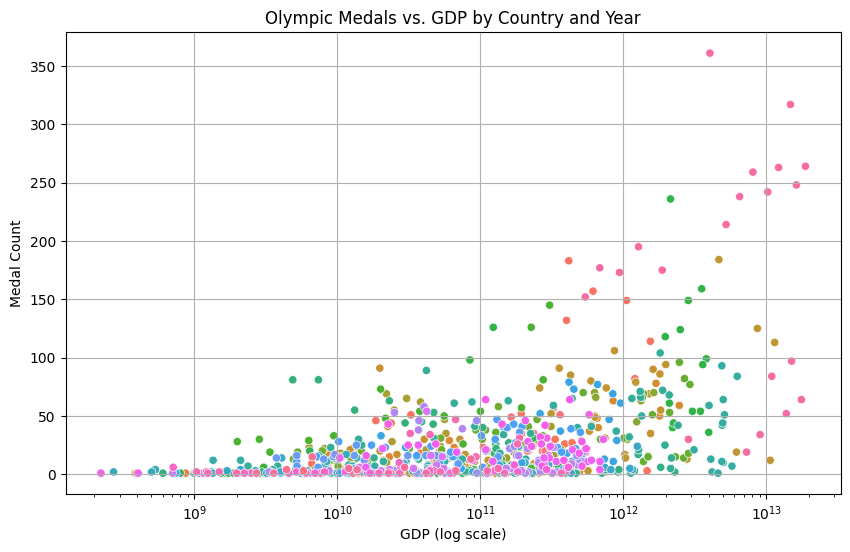

Pearson correlation: 0.56


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Ensure both columns are numeric
filtered['GDP'] = pd.to_numeric(filtered['GDP'], errors='coerce')
filtered['Medal Count'] = pd.to_numeric(filtered['Medal Count'], errors='coerce')

# Drop any rows that couldn't be converted
filtered = filtered.dropna(subset=['GDP', 'Medal Count'])

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered, x='GDP', y='Medal Count', hue='Team', legend=False)
plt.xscale('log')  # GDP ranges widely, log scale helps
plt.xlabel('GDP (log scale)')
plt.ylabel('Medal Count')
plt.title('Olympic Medals vs. GDP by Country and Year')
plt.grid(True)
plt.show()

# Pearson correlation
corr, _ = pearsonr(filtered['GDP'], filtered['Medal Count'])
print(f'Pearson correlation: {corr:.2f}')


In [ ]:
import statsmodels.api as sm
import numpy as np

# Step 1: Prepare variables
X = filtered['GDP']
y = filtered['Medal Count']

# Add constant (intercept) for regression
X = sm.add_constant(X)

# Step 2: Fit linear regression
model = sm.OLS(y, X).fit()
filtered['Predicted Medals'] = model.predict(X)

# Step 3: Calculate residuals (actual - predicted)
filtered['Residual'] = filtered['Medal Count'] - filtered['Predicted Medals']

# Step 4: Sort by residuals to find outliers
outliers = filtered[['Team', 'Year', 'Medal Count', 'GDP', 'Predicted Medals', 'Residual']]
outliers = outliers.sort_values(by='Residual', ascending=False)

# Show top 10 overperformers
print("Top Overperformers (actual medals > predicted):")
print(outliers.head(10))

# Show bottom 10 underperformers
print("\nTop Underperformers (actual medals < predicted):")
print(outliers.tail(10))


Top Overperformers (actual medals > predicted):
                Team  Year  Medal Count           GDP  Predicted Medals  \
27553  United States  1984          361  4.037613e+12         64.877919   
15403        Germany  1992          236  2.141378e+12         42.138156   
27262  United States  1972          195  1.279110e+12         31.797794   
913        Australia  2000          183  4.161678e+11         21.449343   
27068  United States  1964          177  6.856316e+11         24.680768   
27941  United States  1996          259  8.073122e+12        113.271973   
27165  United States  1968          173  9.416391e+11         27.750824   
27747  United States  1992          238  6.520327e+12         94.650767   
27359  United States  1976          175  1.873412e+12         38.924698   
27650  United States  1988          214  5.236438e+12         79.254297   

         Residual  
27553  296.122081  
15403  193.861844  
27262  163.202206  
913    161.550657  
27068  152.319232  
27941 

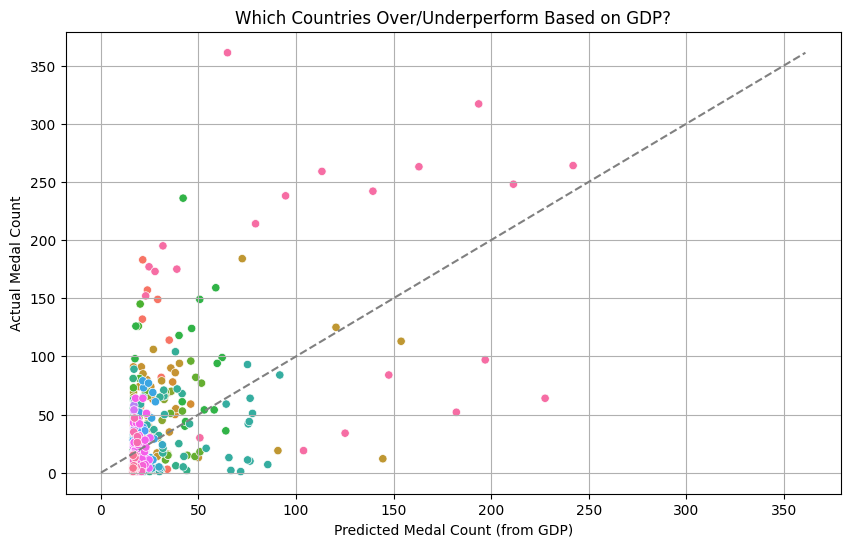

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered, x='Predicted Medals', y='Medal Count', hue='Team', legend=False)

# Reference line (y = x)
max_val = max(filtered['Medal Count'].max(), filtered['Predicted Medals'].max())
plt.plot([0, max_val], [0, max_val], '--', color='gray')

plt.xlabel('Predicted Medal Count (from GDP)')
plt.ylabel('Actual Medal Count')
plt.title('Which Countries Over/Underperform Based on GDP?')
plt.grid(True)
plt.show()

/tmp/ipython-input-21-2584724948.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_total, x='Medal Count', y='NOC', palette='viridis')


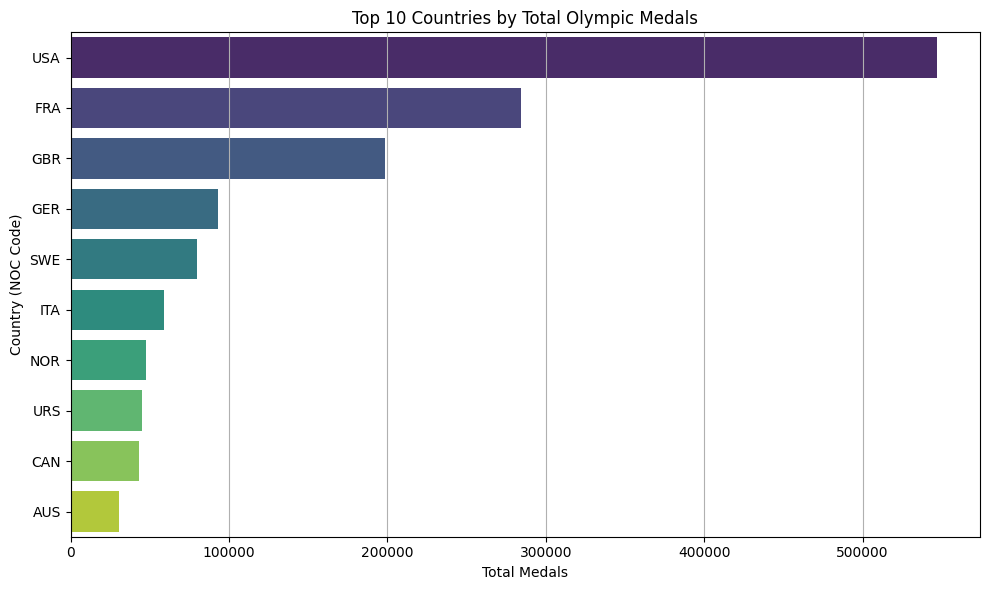

In [ ]:
# Total medals per country (across all years)
top_total = medals_with_country.groupby('NOC')['Medal Count'].sum().reset_index()
top_total = top_total.sort_values(by='Medal Count', ascending=False).head(10)
top_total_named = top_total.merge(noc_country_map, on='NOC', how='left')


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=top_total, x='Medal Count', y='NOC', palette='viridis')
plt.title('Top 10 Countries by Total Olympic Medals')
plt.xlabel('Total Medals')
plt.ylabel('Country (NOC Code)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

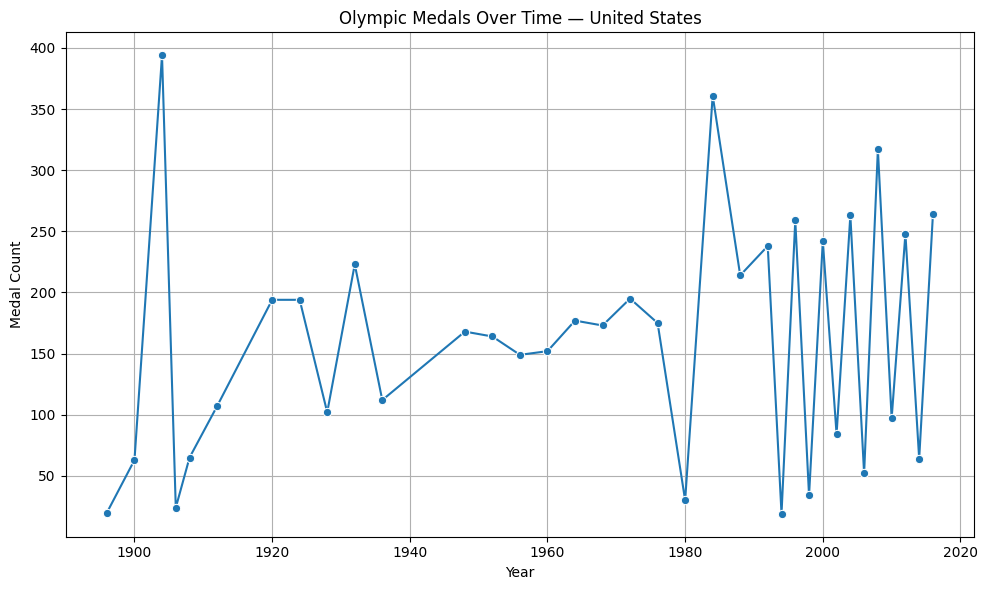

In [ ]:
usa_trend = medals_with_country[medals_with_country['Team'] == 'United States']

# Group by year
usa_trend = usa_trend.groupby('Year')['Medal Count'].sum().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=usa_trend, x='Year', y='Medal Count', marker='o')
plt.title('Olympic Medals Over Time — United States')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
filtered.to_csv('olympics_gdp_final.csv', index=False)